# MFCC (Mel Frequency Cepstral Coefficients)

Author: L. Iacussi

This notebook shows an example of data analysis for acceleration acquisitions that have been collected on a simple system with a motor, a magnet to induce disturbance and STWIN. The purpose of this study is verifying that MFCC features, widely used in audio, can also be used with accelerometer time series.

![](motorstwin_2.png)

Calculation of the MFCC using CMSIS Digital Signal Processing Library and relative Python Wrapper.

[CMSIS DSP library](https://github.com/STMicroelectronics/STM32CubeU5/tree/main/Drivers/CMSIS/DSP) is made by ARM and it is optimized for its microcontroller cores, including of course STM32 series by STMicroelectronics. The [Python wrapper](https://developer.arm.com/documentation/102463/latest/) for the CMSIS DSP functions allows experimenting with them in a Python notebook. It ensures that processing results will be equivalent when porting an algorithm to a microcontroller and using C.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Import_functions import *
from CMSIS_Functions import *
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import plotly.express as px
import plotly.graph_objects as go
lb = preprocessing.LabelBinarizer()

### Accelerometric data spectrum

Load data coming from a 3-axes accelerometer attached to a motor. The aim of this study it to classify the time series acceleration data in four classes:
- Slow
- Fast
- Slow with disturbance
- Fast with disturbance 

Data have been collected using the highest available sampling frequency of 6667 Hz.
It is possible to study the classification problem considering also lower sampling frequency adjusting the Resampling_frequency parameter with one of the following frequency values corresponding to the available STWIN output data rate:
- 12.5
- 26
- 52
- 104
- 208
- 416
- 833
- 1666
- 3332
- 6667


Moreover as the spectrum has been calculated considering the welch method a number of spectrum averages must be choosen.

In [2]:
# The user must choose these parameters
Resampling_frequency = 1666
number_of_averages=500
Accelerometer_axis = 'y'

# Load acceleration data
df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = load_data(resampling_active=True, Resampling_frequency=Resampling_frequency)

# Spectrum calculation
freq_S, P_spectr_S = signal_welch(df_ACC_S, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)
freq_F, P_spectr_F = signal_welch(df_ACC_F, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)
freq_SD, P_spectr_SD = signal_welch(df_ACC_SD, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)
freq_FD, P_spectr_FD = signal_welch(df_ACC_FD, sensor_Type='A_'+Accelerometer_axis+' [g]', n_avg = number_of_averages)

fig = px.line( title='Power Spectrum')
fig.add_scatter(x=freq_S, y=P_spectr_S, name = "slow", marker =dict(size = 0.2, color = 'blue'),line = dict(width=1))
fig.add_scatter(x=freq_F, y=P_spectr_F, name = "fast", marker =dict(size = 0.2, color = 'red'),line = dict(width=1))
fig.add_scatter(x=freq_SD, y=P_spectr_SD, name = "slow dist", marker =dict(size = 0.2,color = 'green'), line = dict(width=1))
fig.add_scatter(x=freq_FD, y=P_spectr_FD, name = "fast dist", marker =dict(size = 0.2,color = 'black'),line = dict(width=1))

fig.update_layout( 
    xaxis_title="freq [Hz]",
    yaxis_title="Amplitude [(m/s^2)^2]",)

fig.show()

Measured ODR: 6917.174621034457

ODR after resampling: 1666.0000000000005


<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## MFCC Calculation process

Based on the previously choosen accelerometer axis the accelerometric signal must be stored in a numpy array in order to calculate the MFCC

Calculation sequence:
- Hanning window
- Power spectrum (FFT)
- Mel spectrum using the DCT of the Power Spectrum
- 20*log(Mel Spectrum)

<br>
<br>

User input parameters: 
- Number of DCT Output: from 0 to number of MelFilters
- Number of Mel Filters: 128 or 512 (Fixed in this CMSIS DSP Lib version)
- n_samples: 1024, 2048, ...
- shift_samples: for data augmentation purpose

In [ ]:
signal_S = np.array( df_ACC_S['A_'+Accelerometer_axis+' [g]'] )
signal_F = np.array( df_ACC_F['A_'+Accelerometer_axis+' [g]'] )
signal_SD = np.array( df_ACC_SD['A_'+Accelerometer_axis+' [g]']  )
signal_FD = np.array( df_ACC_FD['A_'+Accelerometer_axis+' [g]']  )

In [ ]:
numOfDctOutputs = 128
numOfMelFilters = 128
n_samples = 512
shift_samples=50

mcc_spectrogram_matrix_S = CMSIS_MFCC_Spectrogram_V4(signal = signal_S,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_F = CMSIS_MFCC_Spectrogram_V4(signal = signal_F,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_SD = CMSIS_MFCC_Spectrogram_V4(signal = signal_SD,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_FD = CMSIS_MFCC_Spectrogram_V4(signal = signal_FD,
                                                      sampling_frequency=Resampling_frequency,
                                                      freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

In [ ]:
ax_S = show_specgram(mcc_spectrogram_matrix_S, 0.7, [0, len(signal_S)/Resampling_frequency, 128 ,1], cmin =-800, title='Slow '+Accelerometer_axis, y_axis = "Mel Frequency")
ax_F = show_specgram(mcc_spectrogram_matrix_F, 0.7, [0, len(signal_F)/Resampling_frequency, 128 ,1], cmin = -800, title='Fast '+Accelerometer_axis,  y_axis = "Mel Frequency")
ax_SD = show_specgram(mcc_spectrogram_matrix_SD, 0.7, [0, len(signal_SD)/Resampling_frequency, 128 ,1], cmin = -800, title='Slow Disturbances '+Accelerometer_axis,  y_axis = "Mel Frequency")
ax_FD = show_specgram(mcc_spectrogram_matrix_FD, 0.7, [0, len(signal_FD)/Resampling_frequency, 128 ,1], cmin = -800, title='Fast Disturbances '+Accelerometer_axis,  y_axis = "Mel Frequency")

<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Feature separability analysis

It is possible to use the MFCC features for signal classification purpose, in this example it is shown how the four classes can be separated using a dimensionality reduction  technique (Linear Discriminant Analysis) applied to the 128 Mel Frequency Cepstrum Coefficients.

<br>



### k-NN Accuracy Test

The classification has been tested using k-NN classification algorithm on the dataset when dimensionality reduction technique is applied and not applied

In [ ]:
X_S = mcc_spectrogram_matrix_S.T
X_F = mcc_spectrogram_matrix_F.T
X_SD = mcc_spectrogram_matrix_SD.T
X_FD = mcc_spectrogram_matrix_FD.T

y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

X = np.concatenate((X_S,X_F,X_SD,X_FD))
y = np.concatenate((y_S,y_F,y_SD,y_FD))


# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]


lda = LDA(n_components=2)
x_lda = lda.fit_transform(X, y)

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_lda[:,0], x_lda[:,1], c=y, cmap = 'viridis')

plt.legend(handles=scatter.legend_elements()[0], labels=['Slow','Fast','Slow Dist','Fast Dist'])
plt.title("Embedded space with LDA")
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

n_classes = len(np.unique(y))
n_neighbors = 5
lda = make_pipeline(StandardScaler(), LDA(n_components=3))
knn = KNeighborsClassifier(n_neighbors=n_neighbors)

lda.fit(X_train, y_train)
knn.fit(lda.transform(X_train), y_train)
acc_knn = knn.score(lda.transform(X_test), y_test)
print('\nAccuracy with dimensionality reduction technique:   ', acc_knn, '\n')

knn.fit(X_train, y_train)
acc_knn = knn.score(X_test, y_test)
print('Accuracy without dimensionality reduction technique:   ', acc_knn)

In [ ]:

# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb.fit(y)
y=lb.transform(y)
print(y.shape)

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

outputShape=4
model = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape = (trainX.shape[1])),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense( 256 , activation='relu'),
    tf.keras.layers.Dense( 128 , activation='relu'),
    tf.keras.layers.Dense( 56 , activation='relu'),
    tf.keras.layers.Dense( 56 , activation='relu'),
    tf.keras.layers.Dense( 56 , activation='relu'),
    tf.keras.layers.Dense( 56 , activation='relu'),
    tf.keras.layers.Dropout( 0.2 ),
    tf.keras.layers.Dense( outputShape, activation = 'softmax' ) 
    ])

# the user can change the learning rate and the batch size
learningRate = 1e-5
batchSize = 128

_, score = evaluate_model(trainX, trainY ,
                                    validationX, validationY, 
                                    testX, testY, 
                                    model,
                                    learningRate = learningRate,
                                    batchSize = batchSize,
                                    verbosity = 1,
                                    ConfusionMatrix=True,
                                    learning_curves=True)


modelSave(model, 'mfcc')

<br>
<br>
<br>
<br>

# Fine tuning

Fine tuning of the pre-trained model with data collected using HSDatalog and setting the correct samling frequency without resampling.



In [3]:
# Load acceleration data
df_ACC_S, df_ACC_F, df_ACC_SD, df_ACC_FD = load_data(resampling_active=False, folder_name = 'New_acquisition_fine_tuning')

signal_S = np.array( df_ACC_S['A_'+Accelerometer_axis+' [g]'] )
signal_F = np.array( df_ACC_F['A_'+Accelerometer_axis+' [g]'] )
signal_SD = np.array( df_ACC_SD['A_'+Accelerometer_axis+' [g]']  )
signal_FD = np.array( df_ACC_FD['A_'+Accelerometer_axis+' [g]']  )

numOfDctOutputs = 128
numOfMelFilters = 128
n_samples = 512
shift_samples=50

mcc_spectrogram_matrix_S = CMSIS_MFCC_Spectrogram_V4(signal = signal_S,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_F = CMSIS_MFCC_Spectrogram_V4(signal = signal_F,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_SD = CMSIS_MFCC_Spectrogram_V4(signal = signal_SD,
                                                     sampling_frequency=Resampling_frequency,
                                                     freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

mcc_spectrogram_matrix_FD = CMSIS_MFCC_Spectrogram_V4(signal = signal_FD,
                                                      sampling_frequency=Resampling_frequency,
                                                      freq_min = 0,
                                                     numOfDctOutputs=numOfDctOutputs, 
                                                     numOfMelFilters = numOfMelFilters , 
                                                     n_samples = n_samples, 
                                                     shift_samples=shift_samples)

Measured ODR: 1783.3963183029373

ODR after resampling: 1783.3963183029373


### Dataset preparation

In [4]:
X_S = mcc_spectrogram_matrix_S.T
X_F = mcc_spectrogram_matrix_F.T
X_SD = mcc_spectrogram_matrix_SD.T
X_FD = mcc_spectrogram_matrix_FD.T

y_S = np.ones(len(X_S))*0
y_F = np.ones(len(X_F))*1
y_SD = np.ones(len(X_SD))*2
y_FD = np.ones(len(X_FD))*3

X = np.concatenate((X_S,X_F,X_SD,X_FD))
y = np.concatenate((y_S,y_F,y_SD,y_FD))

# Data randomization
idx = np.random.permutation(len(X))
X = X[idx]
y=y[idx]

# Binarization of categorical labels
# From a single vector containing the class number from 0 to 4 
# To a matrix of dimension len(y) and 4 columns cotaining 0 or 1 based for each label
lb.fit(y)
y=lb.transform(y)
print(y.shape)

# train/test split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=1)
trainX, validationX, trainY, validationY = train_test_split(trainX, trainY, test_size=0.25, random_state=1)

(17080, 4)


## Load and train an existing model

Load the existing model from **Saved_models** folder and train that model using new acquired data.

It is possible to include or not the top layer and to choose the number of trainable layers (with -1 all layers are trainable)

After the training it is possible to overwrite the existing model or to save a model with a different name

2022-05-05 12:35:05.496842: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-05 12:35:05.497473: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 128)               0         
_________________________________________________________________
sequential (Sequential)      (None, 128)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 56)                82720     
_________________________________________________________________
sequential_3 (Sequential)    (None, 4)                 228       
Total params: 82,948
Trainable params: 82,948
Non-trainable params: 0
_________________________________________________________________
Train on 10248 samples, validate on 3416 samples
Epoch 1/5000
10248/10248 [==============================] - 2s 204us/sample - loss: 0.6822 - acc: 0.8586 - val_loss: 0.4349 - val_acc: 0.9011
Epoch 2/5000
10248/10248 [==============================]

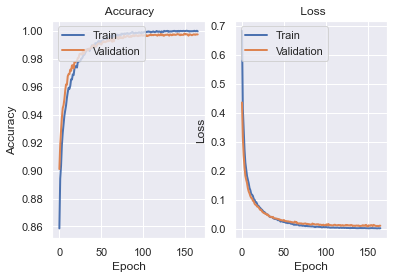

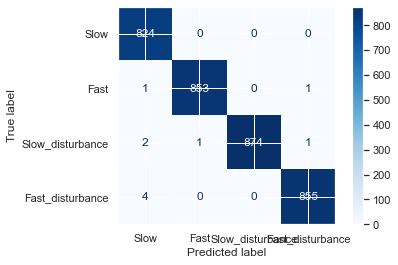

precision:  [0.99157641 0.99882904 1.         0.99766628]
recall:  [1.         0.99766082 0.99544419 0.99534342]


2022-05-05 12:38:05.498498: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Saved_models/mfcc/assets


In [5]:
model_1 = load_existing_model('mfcc', n_last_trainable_layers = -1, out_layer = True)

# the user can change the learning rate and the batch size
learningRate = 1e-5
batchSize = 128

_, score = evaluate_model(trainX, trainY ,
                                    validationX, validationY, 
                                    testX, testY, 
                                    model_1,
                                    learningRate = learningRate,
                                    batchSize = batchSize,
                                    verbosity = 1,
                                    ConfusionMatrix=True,
                                    learning_curves=True)


modelSave(model_1, 'mfcc')